In [1]:
from pytorch_lightning.utilities import grad_norm
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from copy import deepcopy
from sklearn.metrics import silhouette_score
import pandas as pd 
import torch.optim as optim
from braingeneers.analysis import SpikeData
import os
import json
import pytorch_lightning as pl
from backbones import ResNet18Enc, ResNet18Dec
import wandb
import pickle
from tqdm import tqdm
import scanpy as sc 
import matplotlib.pyplot as plt 
from torch.optim.lr_scheduler import ReduceLROnPlateau
import anndata as an 
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
import umap
from collections import Counter


/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# #File loader for the non labeled data
# waveform_files = ["data/" + f for f in os.listdir("./data") if f.endswith('.npy')]
# meta_files = [f.replace('.npy', '.json') for f in waveform_files]

# waveforms = []
# isi_dist = []

# for wf, mf in zip(waveform_files, meta_files):
#     with open(mf, 'r') as file:
#         json_data = json.load(file)

#     sd = SpikeData([json_data[key]['train'] for key in json_data.keys()])
#     trains = sd.train

#     all_isi = sd.interspike_intervals()
    
#     bad_indices = []
#     for idx, isi in enumerate(all_isi):
#         hist, _ = np.histogram(isi[isi < 0.1], bins=64, density=True)
#         if not np.isnan(hist).all():
#             isi_dist.append(hist)
#         else:
#             bad_indices.append(idx)
    
#     waveform_data = np.load(wf)
#     if bad_indices:
#         waveform_data = np.delete(waveform_data, np.array(bad_indices), axis=0)

#     waveforms.append(waveform_data)
# waveforms = np.concatenate(waveforms, axis=0)
# isi_dist = np.stack(isi_dist)


In [3]:
waveform_files = ["unlabeled_data_templates/processed_data/" + f for f in os.listdir("./unlabeled_data_templates/processed_data/") if f.endswith('templates.npy')]
meta_files = [f.replace('templates.npy', 'isi_distribution.npy') for f in waveform_files]
waveforms = []
isi_dist = []
for wf, mf in zip(waveform_files, meta_files):
    waveform = np.load(wf)
    #print(waveform.shape)
    if waveform.shape[1] == 0:
        continue
    else:
        waveform = np.squeeze(waveform, axis=0)
        isi_dis = np.load(mf)
        #print(waveform.shape)
        #print(isi_dis.shape)
        waveforms.append(waveform)
        isi_dist.append(isi_dis)

waveforms = np.concatenate(waveforms, axis=0)
min_val = np.min(waveforms)
max_val = np.max(waveforms)
waveforms = (waveforms - min_val) / (max_val - min_val)
# Scale to range [-1, 1]
waveforms = waveforms * 2 - 1

#waveforms = (waveforms - waveforms.mean()) / waveforms.std()
#0 1 normalization
#waveforms = (waveforms - waveforms.min()) / (waveforms.max() - waveforms.min())

isi_dists = np.concatenate(isi_dist)
isi_dists = isi_dists / isi_dists.sum(axis=1, keepdims=True)


In [4]:
len(waveforms), len(isi_dists)

(12797, 12797)

In [5]:
#Dataloader dataset
class EphysDataset(Dataset):
    def __init__(self, waveforms, isi_dists, normalize=True):
        self.waveforms = np.array(waveforms)
        self.isi_dists = np.array(isi_dists)
        
        assert len(self.waveforms) == len(self.isi_dists)
        self.normalize = normalize
        
    def __getitem__(self, idx):
        waveform = torch.as_tensor(self.waveforms[idx, ...]).float()
        
        isi_dist = torch.as_tensor(self.isi_dists[idx, ...]).float()
        isi_dist = torch.log(isi_dist + 1)

        if self.normalize:
            #waveform = (waveform - waveform.mean()) / waveform.std()
            #0 1 normalization
            waveform = (waveform - waveform.min()) / (waveform.max() - waveform.min())
            isi_dist = (isi_dist - isi_dist.mean()) / isi_dist.std()

        waveform = waveform.view(1, 1, -1)
        waveform = waveform.view(1,-1)
        #waveform = F.interpolate(waveform, size=(64,), mode='linear').view(1, -1)
        
        isi_dist = isi_dist.view(1, 1, -1)
        isi_dist = isi_dist.view(1,-1)
        #isi_dist = F.interpolate(isi_dist, size=(64,), mode='linear').view(1, -1)

        return waveform, isi_dist
    
    def __len__(self):
        return len(self.waveforms)

In [6]:
wf_train_nolabel, isi_train_nolabel = waveforms[:8000], isi_dists[:8000]
wf_val_nolabel, isi_val_nolabel = waveforms[8000:], isi_dists[8000:]

dataset_train_nolabel = EphysDataset(wf_train_nolabel, isi_train_nolabel, normalize=False)

dataloader_train_nolabel = DataLoader(dataset_train_nolabel, batch_size=64, shuffle=True)

dataset_val_nolabel = EphysDataset(wf_val_nolabel, isi_val_nolabel, normalize=False)
dataloader_val_nolabel = DataLoader(dataset_val_nolabel, batch_size=64, shuffle=False)

In [7]:
#Check the dataloader
for wf, isi in dataloader_train_nolabel:
    print(wf.shape, isi.shape)
    break

torch.Size([64, 1, 50]) torch.Size([64, 1, 100])


In [8]:
import numpy as np
#File loader for warren's loaded data
waveform = np.load('./labeled_data_warren_templates/templates_50.npy')
isi_dist = np.load('./labeled_data_warren_templates/isi_dist_100.npy')
labels = np.load('./labeled_data_warren_templates/label_int.npy')
#Substract 1 from the labels to make them 0-indexed
labels = labels - 1

#Waveform normalization using mean and std deviation
#waveform = waveform[:,0:50]
#waveform = (waveform - waveform.mean()) / waveform.std()
#waveform = (waveform - waveform.min()) / (waveform.max() - waveform.min())
min_val = np.min(waveform)
max_val = np.max(waveform)
waveform = (waveform - min_val) / (max_val - min_val)
# Scale to range [-1, 1]
waveform = waveform * 2 - 1


#Normalize isi_dist to 1 per recording
#isi_dist = isi_dist / isi_dist.sum(axis=1, keepdims=True)

# Convert one-hot to integer class
#labels = np.argmax(labels, axis=1)
labels

array([0, 0, 0, ..., 1, 0, 0])

In [9]:
print(waveform.shape, isi_dist.shape, labels.shape)

(1156, 50) (1156, 100) (1156,)


In [10]:
len(isi_dist[0])
#Check the label distribution
np.unique(labels, return_counts=True)

(array([0, 1, 2]), array([683, 232, 241]))

In [11]:
len(waveform)

1156

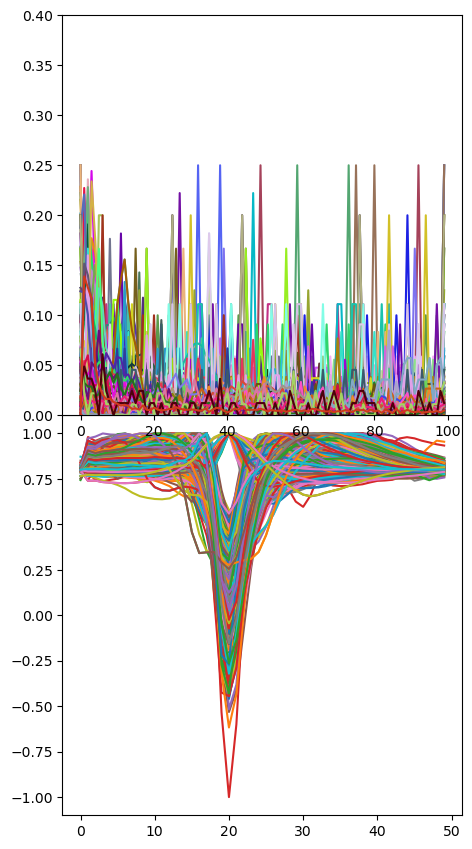

In [12]:
indices_wf = [i for i in range(0, waveforms.shape[1])]
indices_isi = [i for i in range(0, isi_dists.shape[1])]
plt.figure(figsize=(10, 10))
panel1 = plt.axes([0.1, 0.1, 0.4, 0.4])
panel2 = plt.axes([0.1, 0.5, 0.4, 0.4])
panel2.set_ylim(0, 0.4)
#Change waveforms.shape to something more manageable
size = 500
for i in range(0,size):
    panel1.plot(indices_wf, waveforms[i])

#panel1.scatter(indices_wf, waveform[0], c='r', s=1)
for i in range(0, size):
    #print(isi_dist[i])
    #if any value is bigger than 0.25 plot it as grey
    if any(isi_dists[i] > 0.25):
        panel2.plot(indices_isi, isi_dists[i], c='grey',alpha=0)
    else:
        #Random color
        panel2.plot(indices_isi, isi_dists[i], c=np.random.rand(3,))

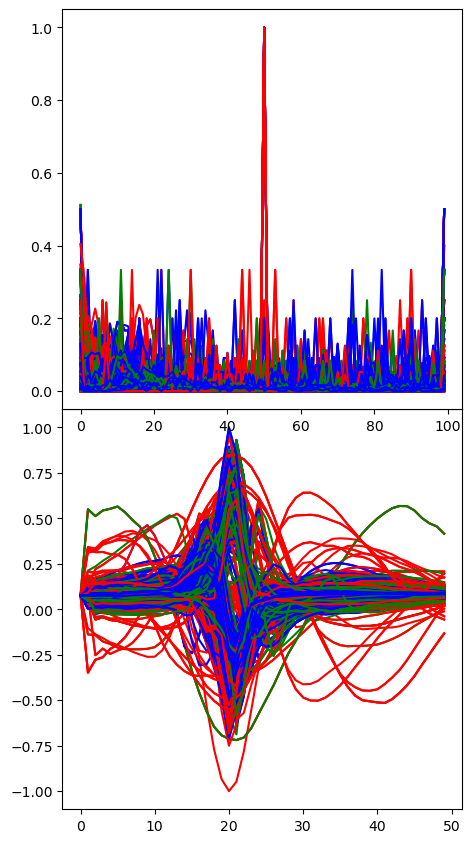

In [13]:
#Plot the data
indices_wf = [i for i in range(0, waveform.shape[1])]
indices_isi = [i for i in range(0, isi_dist.shape[1])]
plt.figure(figsize=(10, 10))
panel1 = plt.axes([0.1, 0.1, 0.4, 0.4])
panel2 = plt.axes([0.1, 0.5, 0.4, 0.4])

colors = ['blue','green','red']
for i in range(0, waveform.shape[0]):
    color = colors[labels[i]]
    panel1.plot(indices_wf, waveform[i], c=color)

#panel1.scatter(indices_wf, waveform[0], c='r', s=1)
for i in range(0, isi_dist.shape[0]):
    #print(isi_dist[i])
    panel2.plot(indices_isi, isi_dist[i], c=colors[labels[i]])

In [14]:
class EphysDatasetLabeled(Dataset):
    def __init__(self, waveforms, isi_dists,labels, normalize=True):
        self.waveforms = np.array(waveforms)
        self.isi_dists = np.array(isi_dists)
        self.labels = np.array(labels)
        #print(len(self.waveforms) , len(self.isi_dists), len(self.labels))
        assert len(self.waveforms) == len(self.isi_dists)
        assert len(self.waveforms) == len(self.labels)
        self.normalize = normalize
        
    def __getitem__(self, idx):
        waveform = torch.as_tensor(self.waveforms[idx, ...]).float()
        
        isi_dist = torch.as_tensor(self.isi_dists[idx, ...]).float()
        isi_dist = torch.log(isi_dist + 1)

        label = torch.as_tensor(self.labels[idx]).long()
        if self.normalize:
            #waveform = (waveform - waveform.mean()) / waveform.std()
            #0 1 normalization
            waveform = (waveform - waveform.min()) / (waveform.max() - waveform.min())
            isi_dist = (isi_dist - isi_dist.mean()) / isi_dist.std()

        waveform = waveform.view(1, 1, -1)
        waveform = waveform.view(1,-1)
        #waveform = F.interpolate(waveform, size=(64,), mode='linear').view(1, -1)
        
        isi_dist = isi_dist.view(1, 1, -1)
        isi_dist = isi_dist.view(1,-1)
        #isi_dist = F.interpolate(isi_dist, size=(64,), mode='linear').view(1, -1)

        return waveform, isi_dist, label
    
    def __len__(self):
        return len(self.waveforms)

In [15]:
# def compute_class_weights(targets):
#     class_counts = Counter(targets)
#     total_count = len(targets)
#     class_weights = {cls: 1/(total_count/count) for cls, count in class_counts.items()}
#     return class_weights
# def BalancedBatchSampler(dataset):
#     targets = [dataset[i][1] for i in range(len(dataset))]
#     class_weights = compute_class_weights(targets)
#     weights = [class_weights[target] for target in targets]
#     print("weights",weights)
#     sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))
#     return sampler


import torch
is_torchvision_installed = True
try:
    import torchvision
except:
    is_torchvision_installed = False
import torch.utils.data
import random

class BalancedBatchSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset, labels=None):
        self.labels = labels
        self.dataset = dict()
        self.balanced_max = 0
        # Save all the indices for all the classes
        for idx in range(0, len(dataset)):
            label = self._get_label(dataset, idx)
            if label not in self.dataset:
                self.dataset[label] = list()
            self.dataset[label].append(idx)
            self.balanced_max = len(self.dataset[label]) \
                if len(self.dataset[label]) > self.balanced_max else self.balanced_max
        
        # Oversample the classes with fewer elements than the max
        for label in self.dataset:
            while len(self.dataset[label]) < self.balanced_max:
                self.dataset[label].append(random.choice(self.dataset[label]))
        self.keys = list(self.dataset.keys())
        self.currentkey = 0
        self.indices = [-1]*len(self.keys)

    def __iter__(self):
        while self.indices[self.currentkey] < self.balanced_max - 1:
            self.indices[self.currentkey] += 1
            yield self.dataset[self.keys[self.currentkey]][self.indices[self.currentkey]]
            self.currentkey = (self.currentkey + 1) % len(self.keys)
        self.indices = [-1]*len(self.keys)
    
    def _get_label(self, dataset, idx, labels = None):
        if self.labels is not None:
            return self.labels[idx].item()
        else:
            # Trying guessing
            dataset_type = type(dataset)
            if is_torchvision_installed and dataset_type is torchvision.datasets.MNIST:
                return dataset.train_labels[idx].item()
            elif is_torchvision_installed and dataset_type is torchvision.datasets.ImageFolder:
                return dataset.imgs[idx][1]
            else:
                raise Exception("You should pass the tensor of labels to the constructor as second argument")

    def __len__(self):
        return self.balanced_max*len(self.keys)


In [16]:
#Load EphysDatasetLabel

wf_train, isi_train,label_train = waveform[:400], isi_dist[:400], labels[:400]
wf_val, isi_val,label_val = waveform[400:], isi_dist[400:], labels[400:]

dataset_train = EphysDatasetLabeled(wf_train, isi_train, label_train, normalize=False)
#Get all labels from dataset_train as a torch tensor
targets = torch.tensor([dataset_train[i][2] for i in range(len(dataset_train))])

sampler = BalancedBatchSampler(dataset_train,targets) #Ańadido aqui
#print(sampler)
dataloader_train = DataLoader(dataset_train, batch_size=32, sampler=sampler)

dataset_val = EphysDatasetLabeled(wf_val, isi_val, label_val, normalize=False)
targets_val = torch.tensor([dataset_val[i][2] for i in range(len(dataset_val))])
sampler = BalancedBatchSampler(dataset_val,targets_val) #Ańadido aqui
#print(sampler)
dataloader_val = DataLoader(dataset_val, batch_size=32, sampler=sampler)
#dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=False)

#Check distribution of label train and label val
print(np.unique(label_train, return_counts=True), np.unique(label_val, return_counts=True))

(array([0, 1, 2]), array([287,  80,  33])) (array([0, 1, 2]), array([396, 152, 208]))


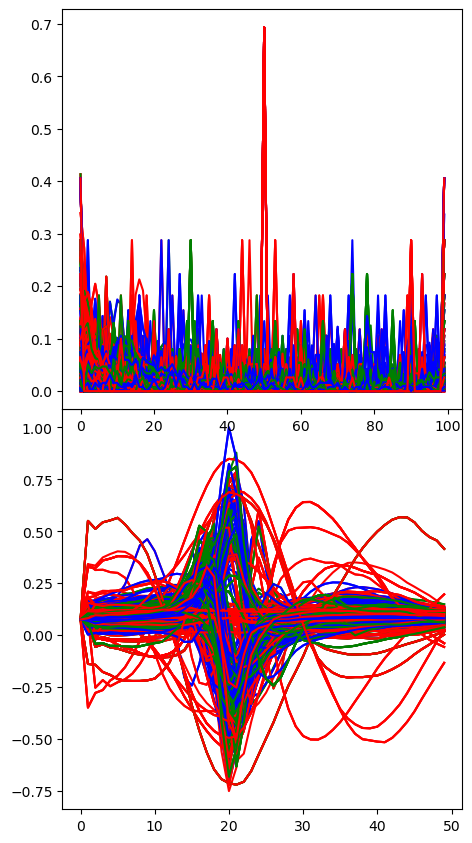

In [17]:
dataloader_waveform = []
dataloader_isi = []
dataloader_labels = []
for i, (wave, time,label) in enumerate(dataloader_val):
    dataloader_waveform.append(wave)
    dataloader_isi.append(time)
    dataloader_labels.append(label)

dataloader_waveform = torch.cat(dataloader_waveform, dim=0)
dataloader_isi = torch.cat(dataloader_isi, dim=0)
dataloader_labels = torch.cat(dataloader_labels, dim=0)

#Plot the data
indices_wf = [i for i in range(0, dataloader_waveform.shape[2])]
indices_isi = [i for i in range(0, dataloader_isi.shape[2])]
plt.figure(figsize=(10, 10))
panel1 = plt.axes([0.1, 0.1, 0.4, 0.4])
panel2 = plt.axes([0.1, 0.5, 0.4, 0.4])

labelColor = ['b', 'g', 'r', 'y', 'm', 'c', 'k', 'w']

for i in range(0, dataloader_waveform.shape[0]):
    panel1.plot(indices_wf, dataloader_waveform[i].squeeze().numpy(), labelColor[dataloader_labels[i].numpy()])

#panel1.scatter(indices_wf, waveform[0], c='r', s=1)
for i in range(0, dataloader_waveform.shape[0]):
    #print(isi_dist[i])
    panel2.plot(indices_isi, dataloader_isi[i].squeeze().numpy(), labelColor[dataloader_labels[i].numpy()])


    

In [18]:
#Loss function

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

class CLIPLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.register_buffer("temperature", torch.tensor(temperature))
            
    def forward(self, emb_i, emb_j):
        logits = (emb_i @ emb_j.T) / self.temperature
        emb_i_similarity = emb_i @ emb_i.T
        emb_j_similarity = emb_j @ emb_j.T

        targets = F.softmax(
            (emb_i_similarity + emb_j_similarity) / 2 * self.temperature, dim=-1
        )

        emb_i_loss = cross_entropy(logits, targets, reduction='none')
        emb_j_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (emb_i_loss + emb_j_loss) / 2.0 # shape: (batch_size)
        return loss.mean()

In [19]:
class UnimodalModel(nn.Module):
    def __init__(self,z_dim,output_size, projector=True):
        super().__init__()
        
        self.encoder = nn.Sequential(
            ResNet18Enc(z_dim=z_dim),
            nn.Linear(z_dim*2, z_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.BatchNorm1d(z_dim),
            nn.Linear(z_dim, z_dim*2),
            nn.BatchNorm1d(z_dim*2),
            ResNet18Dec(z_dim=z_dim,output_size = output_size)
        )
        
    def forward(self, x):
        x = x + torch.randn_like(x)*0.1
        enc_x = self.encoder(x)
        dec_x = self.decoder(enc_x)
        
        return enc_x, dec_x

class UnimodalEmbeddingModel(pl.LightningModule):
    def __init__(self, mode, base_model):
        super().__init__()
        assert mode in ("wave", "time")
        self.mode = mode
        self.model = base_model

        self.mse_loss = nn.MSELoss()
        self.val_loss = []
        self.train_loss = []

    def training_step(self, batch, batch_idx):
        if self.mode == "wave":
            data = batch[0]
        else:
            data = batch[1]
        
        enc, dec = self.model(data)
        loss = self.mse_loss(dec, data)
        
        norms = grad_norm(self.model.encoder, norm_type=2)
        self.log_dict(norms)
        norms = grad_norm(self.model.decoder, norm_type=2)
        self.log_dict(norms)

        self.train_loss.append(loss.item())
        self.log('train_loss', loss)
        
        return loss

    def validation_step(self, batch, batch_idx):
        if self.mode == "wave":
            data = batch[0]
        else:
            data = batch[1]
        
        enc, dec = self.model(data)
        loss = self.mse_loss(dec, data)
        
        self.val_loss.append(loss.item())
        self.log('val_loss', loss)
        
        return loss
    
    def on_validation_epoch_end(self):
        avg_loss = sum(self.val_loss) / len(self.val_loss)
        print(f"Average validation loss is {avg_loss:.2f}")
        self.val_loss = []
        
    def on_train_epoch_end(self):
        avg_loss = sum(self.train_loss) / len(self.train_loss)
        print(f"Average training loss is {avg_loss:.2f}")
        self.train_loss = []

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.01)
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8)

        return {
            "lr_scheduler": {
                "scheduler": lr_scheduler,
                "monitor": "val_loss",
            },
            "optimizer": optimizer,
        }
    
    def forward(self, x):
        return self.model(x)

In [20]:
print(len(waveforms), len(isi_dists))
print(len(waveform), len(isi_dist), len(labels))
#Concatenate waveforms and waveform
#waveforms = np.concatenate([waveforms, waveform], axis=0)

12797 12797
1156 1156 1156


In [26]:
from sklearn.model_selection import train_test_split

def train_unimodal_model(mode):
    wandb.init(reinit=True)
    if mode == "wave":
        inputsize = 50
    else:
        inputsize = 100
    bs = 64
    wf_train = np.concatenate([waveforms[:8000], waveform[:800]], axis=0)
    #wf_train = waveforms[:8000]
    isi_train = np.concatenate([isi_dists[:8000], isi_dist[:800]], axis=0)
    #isi_train = isi_dists[:8000]
    wf_val = waveforms[8000:]
    #wf_val = waveforms[8000:]
    isi_val = isi_dists[8000:]
    
    traindata = EphysDataset(wf_train, isi_train)
    valdata = EphysDataset(wf_val, isi_val)

    train_loader = DataLoader(traindata, batch_size=bs, drop_last=True)
    val_loader = DataLoader(valdata, batch_size=bs, drop_last=True)

    base_model = UnimodalModel(z_dim=5,output_size=inputsize)

    model = UnimodalEmbeddingModel(mode=mode, base_model=base_model)
    ckpt_callback = pl.callbacks.ModelCheckpoint(dirpath=f"./unimodal_model/{mode}_model_templates_noise_100dist", monitor="val_loss")

    trainer = pl.Trainer(
        logger=pl.loggers.WandbLogger(),
        callbacks=[ckpt_callback],
        log_every_n_steps=5,
        max_epochs=100,
    )

    trainer.fit(model, train_loader, val_loader)
    
    return base_model

In [27]:
class MixedModel(nn.Module):
    def __init__(self, z_dim, projector=True):
        super().__init__()
        
        self.wave_encoder = nn.Sequential(
            ResNet18Enc(z_dim=z_dim),
            nn.Linear(z_dim*2, z_dim),
        )
        
        self.wave_decoder = nn.Sequential(
            nn.BatchNorm1d(z_dim),
            nn.Linear(z_dim, z_dim*2),
            nn.BatchNorm1d(z_dim*2),
            ResNet18Dec(z_dim=z_dim)
        )

        self.time_encoder = nn.Sequential(
            ResNet18Enc(z_dim=z_dim),
            nn.Linear(z_dim*2, z_dim),
        )
        
        self.time_decoder = nn.Sequential(
            nn.BatchNorm1d(z_dim),
            nn.Linear(z_dim, z_dim*2),
            nn.BatchNorm1d(z_dim*2),
            ResNet18Dec(z_dim=z_dim)
        )
        
    def forward(self, wave, time):
        e_wave = self.wave_encoder(wave)
        e_time = self.time_encoder(time)

        # e_wave = self.wave_projector(e_wave)
        # e_time = self.time_projector(e_time)

        d_wave, d_time = self.wave_decoder(e_wave), self.time_decoder(e_time)

        return e_wave, e_time, d_wave, d_time

In [23]:
# model = MixedModel(
#     z_dim=5,
# )

# w, t = torch.randn(8, 1, 64), torch.randn(8, 1, 64)

# x,y,z,w = model(w, t)
# x.shape, y.shape, z.shape, w.shape

In [28]:
base_model = MixedModel(z_dim=5)

# with open('./unimodal_model/wave_model.pkl', 'rb') as f:
#     wave_model = pickle.load(f)

# with open('./unimodal_model/isi_model.pkl', 'rb') as f:
#     time_model = pickle.load(f)

In [29]:
print(len(waveforms), len(isi_dists))

12797 12797


In [30]:
wave_model = train_unimodal_model("wave")
time_model = train_unimodal_model("time")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
wandb: Currently logged in as: jesusgf1 (mostajo-group). Use `wandb login --relogin` to force relogin


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory ./unimodal_model/wave_model_templates_noise_100dist exists and is not empty.

  | Name     | Type          | Params
-------------------------------------------
0 | model    | UnimodalModel | 8.0 M 
1 | mse_loss | MSELoss       | 0     
-------------------------------------------
8.0 M     Trainable params
0         Non-trainable params
8.0 M     Total params
32.178    Total estimated model

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Average validation loss is 0.49


/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.19
Average training loss is 0.14


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.03
Average training loss is 0.03


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.03
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.03
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.03
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.03
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.03
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.03
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.03
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.03
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Average validation loss is 0.01
Average training loss is 0.00


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
grad_2.0_norm/0.bias,▂▃▂▁▃▅▅▃▄▂▂▂█▇▂▂▃▃▃▄▂▄▂▃▂▃▂▂▁▄▁▂▁▄▁▂▂▂▃▄
grad_2.0_norm/0.bn1.bias,▂▃▂▁█▁▅▂▃▁▁▁▃▃▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁
grad_2.0_norm/0.bn1.weight,▂▂▂▁█▂▅▂▁▁▁▁▄▃▁▁▁▁▁▁▁▃▂▁▂▁▁▁▁▁▁▂▂▂▁▂▁▁▁▁
grad_2.0_norm/0.conv1.weight,▂▄▂▁█▁█▂▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_2.0_norm/0.layer1.0.bn1.bias,▂▂▃▁█▁▃▂▂▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_2.0_norm/0.layer1.0.bn1.weight,▃▂▂▁█▂▅▂▂▁▁▁▃▃▁▁▁▁▁▁▁▂▂▁▂▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁
grad_2.0_norm/0.layer1.0.bn2.bias,▂▃▃▁█▂▆▂▂▁▁▁▃▂▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁
grad_2.0_norm/0.layer1.0.bn2.weight,▂▂▃▂█▂▆▂▂▁▁▁▄▂▁▁▁▁▁▂▁▂▂▁▂▁▁▁▁▁▁▁▂▂▁▁▁▂▁▁
grad_2.0_norm/0.layer1.0.conv1.weight,▂▃▂▁█▂▆▂▂▁▁▁▃▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_2.0_norm/0.layer1.0.conv2.weight,▃▃▃▂█▂▆▂▂▁▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory ./unimodal_model/time_model_templates_noise_100dist exists and is not empty.

  | Name     | Type          | Params
-------------------------------------------
0 | model    | UnimodalModel | 8.0 M 
1 | mse_loss | MSELoss       | 0     
-------------------------------------------
8.0 M     Trainable params
0         Non-trainable params
8.0 M     Total params
32.191    Total estimated model

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Average validation loss is 0.99


/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.73
Average training loss is 0.86


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.61
Average training loss is 0.67


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.59
Average training loss is 0.62


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.58
Average training loss is 0.60


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.52
Average training loss is 0.57


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.52
Average training loss is 0.55


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.55
Average training loss is 0.53


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.51
Average training loss is 0.52


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.52
Average training loss is 0.52


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.54
Average training loss is 0.52


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.50
Average training loss is 0.51


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.48
Average training loss is 0.51


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.48
Average training loss is 0.50


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.50


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.49


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.49


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.50


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.48


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.48


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.48
Average training loss is 0.48


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.47


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.47


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.47


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.46


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.46


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.46


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.48
Average training loss is 0.45


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.48
Average training loss is 0.45


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.44


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.44


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.43


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.49
Average training loss is 0.44


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.43


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.43


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.48
Average training loss is 0.43


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.49
Average training loss is 0.43


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.49
Average training loss is 0.42


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.41


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.41


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.40


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.40


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.49
Average training loss is 0.38


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.38


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.37


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.37


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.35


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.45
Average training loss is 0.34


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.34


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.44
Average training loss is 0.33


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.45
Average training loss is 0.33


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.45
Average training loss is 0.33


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.44
Average training loss is 0.32


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.45
Average training loss is 0.33


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.45
Average training loss is 0.32


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.45
Average training loss is 0.32


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.44
Average training loss is 0.30


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.43
Average training loss is 0.28


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.44
Average training loss is 0.27


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.44
Average training loss is 0.26


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.44
Average training loss is 0.26


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.44
Average training loss is 0.27


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.45
Average training loss is 0.26


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.45
Average training loss is 0.25


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.44
Average training loss is 0.25


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.45
Average training loss is 0.25


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.45
Average training loss is 0.24


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.24


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.45
Average training loss is 0.24


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.45
Average training loss is 0.23


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.22


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.23


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.22


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.22


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.21


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.45
Average training loss is 0.22


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.45
Average training loss is 0.20


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.45
Average training loss is 0.19


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.45
Average training loss is 0.19


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.45
Average training loss is 0.18


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.18


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.17


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.48
Average training loss is 0.17


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.17


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.18


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.17


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.17


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.17


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.17


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.17


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.17


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.45
Average training loss is 0.16


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.15


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.15


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.15


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.15


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.15


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.15


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.14


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.14


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Average validation loss is 0.46
Average training loss is 0.14


In [31]:
#Save wave_model and time_model as pt
torch.save(wave_model.state_dict(), './unimodal_model/wave_model_50_v2.pt')
torch.save(time_model.state_dict(), './unimodal_model/time_model_100_v2.pt')

In [32]:
#Read wave_model and time_model
wave_model = UnimodalModel(z_dim=5,output_size=50)
time_model = UnimodalModel(z_dim=5,output_size=100)

wave_model.load_state_dict(torch.load('./unimodal_model/wave_model_50_v2.pt'))
time_model.load_state_dict(torch.load('./unimodal_model/time_model_100_v2.pt'))


<All keys matched successfully>

In [ ]:
# # copy over encoder
# base_model.wave_encoder = wave_model.encoder
# base_model.time_encoder = time_model.encoder

# # copy over decoder
# base_model.wave_decoder = wave_model.decoder
# base_model.time_decoder = time_model.decoder

In [ ]:
# torch.save(base_model.state_dict(), 'MixedAutoEncoderTemplates_noise_mix50_100.pt')

In [ ]:
# mixedModelAE = MixedModel(z_dim=5)
# mixedModelAE.load_state_dict(torch.load('MixedAutoEncoderTemplates_noise_mix50_100.pt'))

In [33]:
print(len(waveform))
print(len(isi_dist))

1156
1156


In [34]:
embedding_waveform = []
embedding_isi = []
labels = []
for i, (wave, time,label) in enumerate(dataloader_val):
    e_wave,d_wave = wave_model(wave)
    e_time,d_time = time_model(time)
    embedding_waveform.append(e_wave)
    embedding_isi.append(e_time)
    #print(label)
    labels.append(label)

# for i, (wave,time,label) in enumerate(dataloader_train):
#     e_wave, e_time, d_wave, d_time = mixedModelAE(wave, time)
#     embedding_waveform.append(e_wave)
#     embedding_isi.append(e_time)
#     labels.append(torch.full((len(label),), 3))


embedding_waveform = torch.cat(embedding_waveform, dim=0)
embedding_isi = torch.cat(embedding_isi, dim=0)


In [35]:
#Run Umap in the embeddings
embedding_waveform = embedding_waveform.detach().numpy()
embedding_isi = embedding_isi.detach().numpy()
labels = torch.cat(labels, dim=0).detach().numpy()

In [36]:
#Calculate UMAP
embedding_waveform = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2).fit_transform(embedding_waveform)
embedding_isi = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2).fit_transform(embedding_isi)

In [37]:
labelColor = ['b', 'g', 'r','gray']

In [38]:
labelColor = [labelColor[label] for label in labels]

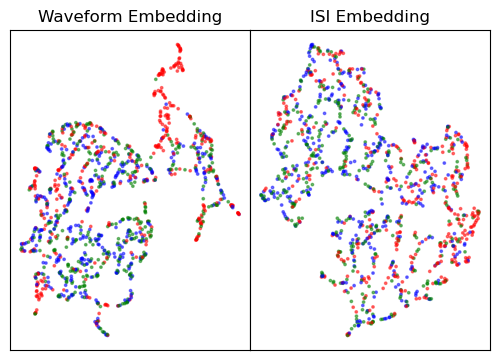

In [39]:
#Plot the embeddings
figureWidth=6
figureHeight=4
plt.figure(figsize=(figureWidth,figureHeight))
panel1 = plt.axes([0.1, 0.1, 0.4, 0.8])
panel2 = plt.axes([0.5, 0.1, 0.4, 0.8])

panel1.scatter(embedding_waveform[:, 0], embedding_waveform[:, 1], color=labelColor, s=3, alpha=0.5)
panel1.set_title("Waveform Embedding")
panel1.set_xticks([])
panel1.set_yticks([])
panel2.scatter(embedding_isi[:, 0], embedding_isi[:, 1], color=labelColor, s=3, alpha=0.5)
panel2.set_title("ISI Embedding")
panel2.set_xticks([])
panel2.set_yticks([])
plt.show()




In [40]:
# from torch.nn.functional import normalize
# class classification(nn.Module):
#     def __init__(self, num_labels, **kwargs):
#         super().__init__()
#         self.mixedModelAE = MixedModel(**kwargs)
#         self.mixedModelAE.load_state_dict(torch.load('MixedAutoEncoderTemplates.pt'))
#         for p in self.mixedModelAE.parameters():
#             p.requires_grad = False
        
#         self.classifier = nn.Sequential(nn.Linear(kwargs['z_dim'] * 2, 64), nn.ReLU(),
#                                          nn.Linear(64, num_labels))
#         #self.classifier = nn.Sequential(nn.Linear(64 * 2, num_labels))
        

#     def forward(self, wave,time):
#         e_wave, e_time, d_wave, d_time = self.mixedModelAE(wave,time)
#         e_wave, e_time = normalize(e_wave), normalize(e_time)
#         #print(e_wave.shape)
#         #print(e_time.shape)
#         x = torch.cat((e_wave, e_time), dim=-1).squeeze()
#         #print(x.shape)
#         output = self.classifier(x)    
#         #print(output.shape)    
#         return output



from torch.nn.functional import normalize
class classification(nn.Module):
    def __init__(self, num_labels, **kwargs):
        super().__init__()
        #self.mixedModelAE = MixedModel(**kwargs)
        #self.mixedModelAE.load_state_dict(torch.load('MixedAutoEncoderTemplates.pt'))
        self.wave_model = UnimodalModel(z_dim=5,output_size=50)
        self.time_model = UnimodalModel(z_dim=5,output_size=100)
        self.wave_model.load_state_dict(torch.load('./unimodal_model/wave_model_50_v2.pt'))
        self.time_model.load_state_dict(torch.load('./unimodal_model/time_model_100_v2.pt'))
        for p in self.wave_model.parameters():
            p.requires_grad = False
        for p in self.time_model.parameters():
            p.requires_grad = False
        
        self.classifier = nn.Sequential(nn.Linear(kwargs['z_dim'] * 2, 64), nn.ReLU(),
                                         nn.Linear(64, num_labels))
        #self.classifier = nn.Sequential(nn.Linear(64 * 2, num_labels))
        

    def forward(self, wave,time):
        #e_wave, e_time, d_wave, d_time = self.mixedModelAE(wave,time)
        e_wave,d_wave = self.wave_model(wave)
        e_time,d_time = self.time_model(time)
        e_wave, e_time = normalize(e_wave), normalize(e_time)
        #print(e_wave.shape)
        #print(e_time.shape)
        x = torch.cat((e_wave, e_time), dim=-1).squeeze()
        #print(x.shape)
        output = self.classifier(x)    
        #print(output.shape)    
        return output

classifier = classification(num_labels=3, z_dim=5)
#Test classifier output shapes
wave = torch.randn(8, 1, 64)
time = torch.randn(8, 1, 64)

output = classifier(wave, time)

In [41]:
for batch in dataloader_train:
    print(batch[2])

tensor([0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1,
        0, 2, 1, 0, 2, 1, 0, 2])
tensor([1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2,
        1, 0, 2, 1, 0, 2, 1, 0])
tensor([2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0,
        2, 1, 0, 2, 1, 0, 2, 1])
tensor([0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1,
        0, 2, 1, 0, 2, 1, 0, 2])
tensor([1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2,
        1, 0, 2, 1, 0, 2, 1, 0])
tensor([2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0,
        2, 1, 0, 2, 1, 0, 2, 1])
tensor([0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1,
        0, 2, 1, 0, 2, 1, 0, 2])
tensor([1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2,
        1, 0, 2, 1, 0, 2, 1, 0])
tensor([2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0,
        2, 1, 0,

In [42]:
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

#Training the classifier

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def train_classifier(classifier, optim, loss_fn, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        cum_loss = 0
        classifier.train()
        correct_train = 0
        total_train = 0
        for i, (wave, time,label) in enumerate(train_loader):
            optimizer.zero_grad()
            output = classifier(wave,time)
            train_predicted = torch.argmax(output, 1)+1
            total_train += time.size(0)
            correct_train += (train_predicted == label).sum().item()
            loss = loss_fn(output,label)
            cum_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch} Iter {i} Loss {cum_loss/len(train_loader)}")
        print(f"Epoch {epoch} Iter {i} Train Accuracy {correct_train / total_train}")
        classifier.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for i, (wave, time,label) in enumerate(val_loader):
                output = classifier(wave,time)
                predicted = torch.argmax(output, 1)+1
                #print(predicted.shape)
                total += time.size(0)
                correct += (predicted == label).sum().item()
            print(f"Epoch {epoch} Validation Accuracy {correct / total}")
        


In [43]:
train_classifier(classifier, optimizer, loss_fn, dataloader_train, dataloader_val, epochs=100)

Epoch 0 Iter 26 Loss 1.099077997384248
Epoch 0 Iter 26 Train Accuracy 0.34610917537746805
Epoch 0 Validation Accuracy 0.2878787878787879
Epoch 1 Iter 26 Loss 1.0768837752165619
Epoch 1 Iter 26 Train Accuracy 0.18815331010452963
Epoch 1 Validation Accuracy 0.3207070707070707
Epoch 2 Iter 26 Loss 1.0615983539157443
Epoch 2 Iter 26 Train Accuracy 0.1916376306620209
Epoch 2 Validation Accuracy 0.30976430976430974
Epoch 3 Iter 26 Loss 1.044748118630162
Epoch 3 Iter 26 Train Accuracy 0.17421602787456447
Epoch 3 Validation Accuracy 0.30976430976430974
Epoch 4 Iter 26 Loss 1.0384954434854012
Epoch 4 Iter 26 Train Accuracy 0.18583042973286876
Epoch 4 Validation Accuracy 0.32323232323232326
Epoch 5 Iter 26 Loss 1.0261980869151928
Epoch 5 Iter 26 Train Accuracy 0.17886178861788618
Epoch 5 Validation Accuracy 0.3148148148148148
Epoch 6 Iter 26 Loss 1.023766435958721
Epoch 6 Iter 26 Train Accuracy 0.19744483159117304
Epoch 6 Validation Accuracy 0.3223905723905724
Epoch 7 Iter 26 Loss 1.014352451871

KeyboardInterrupt: 

In [44]:
#Predict with the classifier

def predict_classifier(classifier, dataloader):
    predictions = []
    classifier.eval()
    labels = []
    with torch.no_grad():
        for i, (wave, time,label) in enumerate(dataloader):
            output = classifier(wave,time)
            predicted = torch.argmax(output, 1)
            predictions.append(predicted)
            labels.append(label)
    return predictions , labels

predictions, label = predict_classifier(classifier, dataloader_val)
predictions = torch.cat(predictions, dim=0).detach().numpy()
label = torch.cat(label, dim=0).detach().numpy()

In [ ]:
len(labels)

1188

In [ ]:
len(predictions)

1188

In [ ]:
len(dataloader_labels)

1188

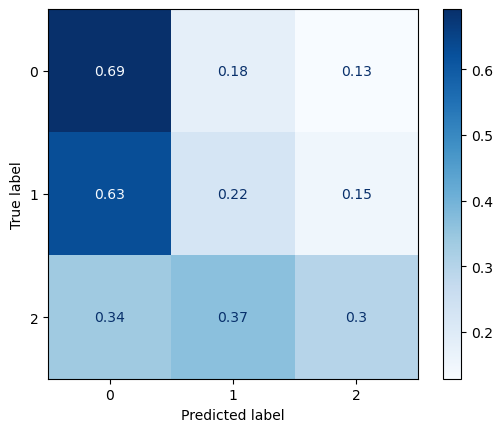

In [45]:
preds_np = predictions
labels_np = labels

# Compute confusion matrix
cm = confusion_matrix(labels_np, preds_np, normalize='true')

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
len(predictions)

1188

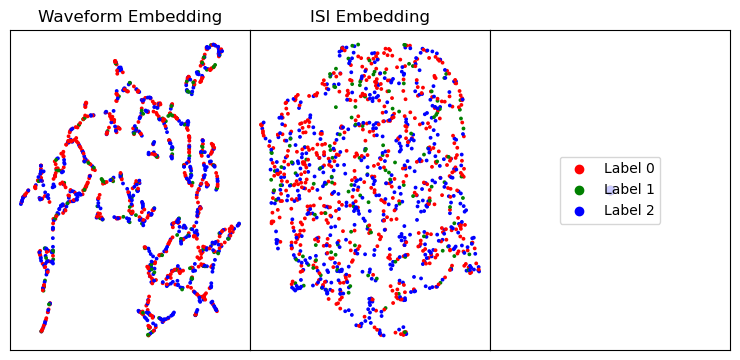

In [ ]:
labelColor = ['b', 'g', 'r','grey']
labelColor = [labelColor[label] for label in predictions]
#Plot the embeddings
figureWidth=6
figureHeight=4
plt.figure(figsize=(figureWidth,figureHeight))
panel1 = plt.axes([0.1, 0.1, 0.4, 0.8])
panel2 = plt.axes([0.5, 0.1, 0.4, 0.8])
panel3 = plt.axes([0.9, 0.1, 0.4, 0.8])
panel1.scatter(embedding_waveform[:, 0], embedding_waveform[:, 1], color=labelColor, s=3)
panel1.set_title("Waveform Embedding")
panel1.set_xticks([])
panel1.set_yticks([])
panel2.scatter(embedding_isi[:, 0], embedding_isi[:, 1], color=labelColor, s=3)
panel2.set_title("ISI Embedding")
panel2.set_xticks([])
panel2.set_yticks([])
#Use panel 3 to plot the color legend labelColor = ['r', 'g', 'b','gray']
panel3.scatter([0], [0], color='r', label='Label 0')
panel3.scatter([0], [0], color='g', label='Label 1')
panel3.scatter([0], [0], color='b', label='Label 2')
panel3.legend(loc='center')
panel3.set_xticks([])
panel3.set_yticks([])

plt.show()